# Calculate whether fast dividers truly posses shortened cell cycle control:

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [2]:
hdf5_file = "../example_segment_classif_tracked_movie.hdf5"


## Calculate whether cycle-length is heritable:

Take full paths tracked from the beginning to the end of movie. Here are some interesting thoughts of what such analysis may help you answer:

+ Calculate whether there is a link between cell cycle times?
+ What is the distribution of cell cycle durations based on the path length? 
+ How many generations can you follow this trend for?


In [5]:
cellC = [[]]
unique_IDs = [[]]

with h5py.File(hdf5_file, "r") as f:
    movie_len = len(f["objects"]["obj_type_1"]["map"])
    ID_list = [item[0] for item in f["tracks"]["obj_type_1"]["LBEPR"]]
    leafs, roots = [], []

    for e, (cell, progeny) in enumerate(zip(f["tracks"]["obj_type_1"]["LBEPR"], f["tracks"]["obj_type_1"]["Ch_Ch_Gen_CCT"])):
            
        if progeny[0] == 0 and progeny[1] == 0:
            if cell[2] == movie_len - 2:
                if cell[3] != cell[4]:
                    leafs.append(cell[0])
                    roots.append(cell[4])

    for leaf in leafs:
        temporary = []
            
        leaf_index = ID_list.index(leaf)
        parent_ID = f["tracks"]["obj_type_1"]["LBEPR"][leaf_index][3]
        parent_index = ID_list.index(parent_ID)
            
        # Check if parent is valuable:
        while f["tracks"]["obj_type_1"]["LBEPR"][parent_index][4] != 0:
            #print (f["tracks"]["obj_type_1"]["LBEPR"][parent_index][0])
            temporary.append(f["tracks"]["obj_type_1"]["Ch_Ch_Gen_CCT"][parent_index][3])
            parent_index = ID_list.index(f["tracks"]["obj_type_1"]["LBEPR"][parent_index][3])
            
        # Now check whether your founder cell reaches to the very beginning of that movie:
        if f["tracks"]["obj_type_1"]["LBEPR"][parent_index][3] == 0:
            if f["tracks"]["obj_type_1"]["LBEPR"][parent_index][1] == 0:
                cellC[0].append(temporary)
                    
                # Take a record of unique founder cell IDs (= trees) in your analysis:
                unique_IDs[0].append(f["tracks"]["obj_type_1"]["LBEPR"][parent_index][0])
                    

In [6]:
counter, counter_unique = 0, 0

for movie in unique_IDs:
    print (f"Total paths: {len(movie)} -> out of which unique root IDs: {len(set(movie))}")
    counter += len(movie)
    counter_unique += len(set(movie))

print (f"\nTotal Lineage Trees: {counter} -> out of which unique tree IDs: {counter_unique} = {round(counter_unique*100/counter, 2)}%")


Total paths: 568 -> out of which unique root IDs: 50

Total Lineage Trees: 568 -> out of which unique tree IDs: 50 = 8.8%


### Sort data based on progeny size:

The paths you want to analyse have different lengths, including 1 (slowest), 2, 3, 4, 5, 6, and 7 intermediate cells: 

In [7]:
hist_data = [[[] for _ in range(e+1)] for e, _ in enumerate(range(7))]

for movie in cellC:
    for path in movie: 
        # Exclude paths which only have 'root - leaf' or 'root - cell - leaf' trajectories:
        if len(path) > 0:
            for e, item in enumerate(path[::-1]):
                hist_data[len(path)-1][e].append(item)


### Plot the histograms of divider subpopulations with ranging cycling speeds

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


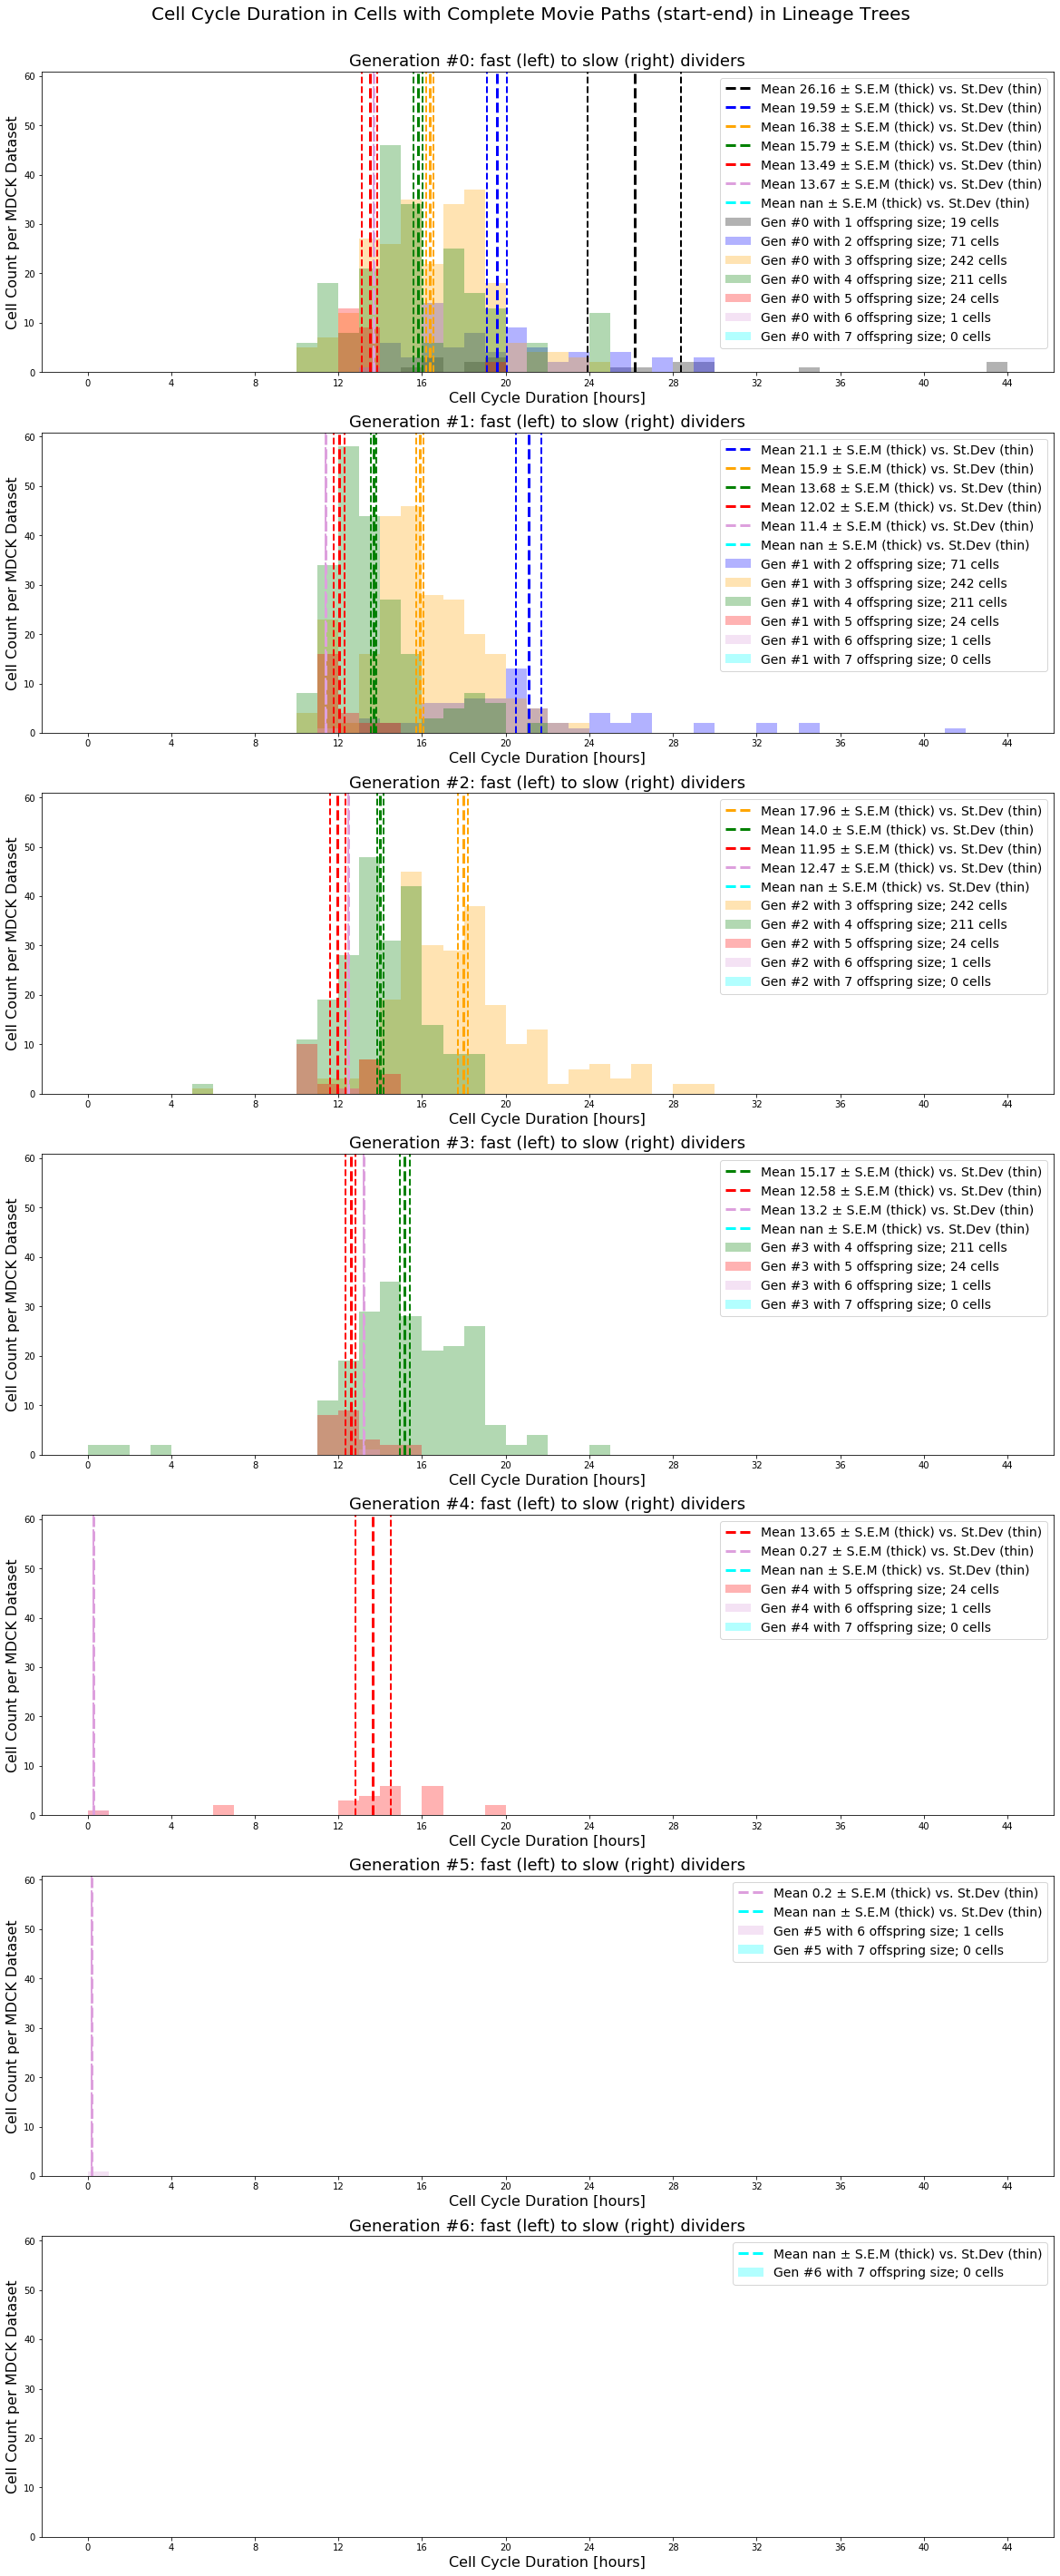

In [8]:
fig, axs = plt.subplots(nrows=len(hist_data), ncols=1, sharey=True, figsize=(20, 50))
fig.suptitle(t="Cell Cycle Duration in Cells with Complete Movie Paths (start-end) in Lineage Trees", x=0.5, y=0.9, fontsize=20)
colours = ["black", "blue", "orange", "green", "red", "plum", "cyan"]

for enum, path in enumerate(hist_data):
    
    for index in range(len(path)):
    
        axs[index].hist(path[index], bins=44, range=(0, 44), alpha=0.3, color=colours[enum], label=f"Gen #{index} with {enum+1} offspring size; {len(path[index])} cells")
        axs[index].axvline(x=np.mean(path[index]), color=colours[enum], linestyle="dashed", linewidth=3, label=f"Mean {round(np.mean(path[index]), 2)} ± S.E.M (thick) vs. St.Dev (thin)")
        axs[index].axvline(x=np.mean(path[index])-(np.std(path[index])/np.sqrt(len(path[index]))), color=colours[enum], linestyle="dashed", linewidth=2)
        axs[index].axvline(x=np.mean(path[index])+(np.std(path[index])/np.sqrt(len(path[index]))), color=colours[enum], linestyle="dashed", linewidth=2)
        
        axs[index].set_title(f"Generation #{index}: fast (left) to slow (right) dividers", fontsize=18)
        axs[index].set_ylabel("Cell Count per MDCK Dataset", fontsize=16)
        axs[index].set_xlabel("Cell Cycle Duration [hours]", fontsize=16)
        axs[index].set_xticks(list(range(0, 45, 4)))
        axs[index].legend(loc="upper right", fontsize=14)

plt.show()


### Plot the final results - generational means ± s.e.m & drifts!

Gen #1 mean = 26.16 -> whole movie duration estimate = 78.0
Gen #1 mean = 19.59 -> whole movie duration estimate = 78.0
Gen #1 mean = 16.38 -> whole movie duration estimate = 82.0
Gen #1 mean = 15.79 -> whole movie duration estimate = 95.0
Gen #1 mean = 13.49 -> whole movie duration estimate = 94.0


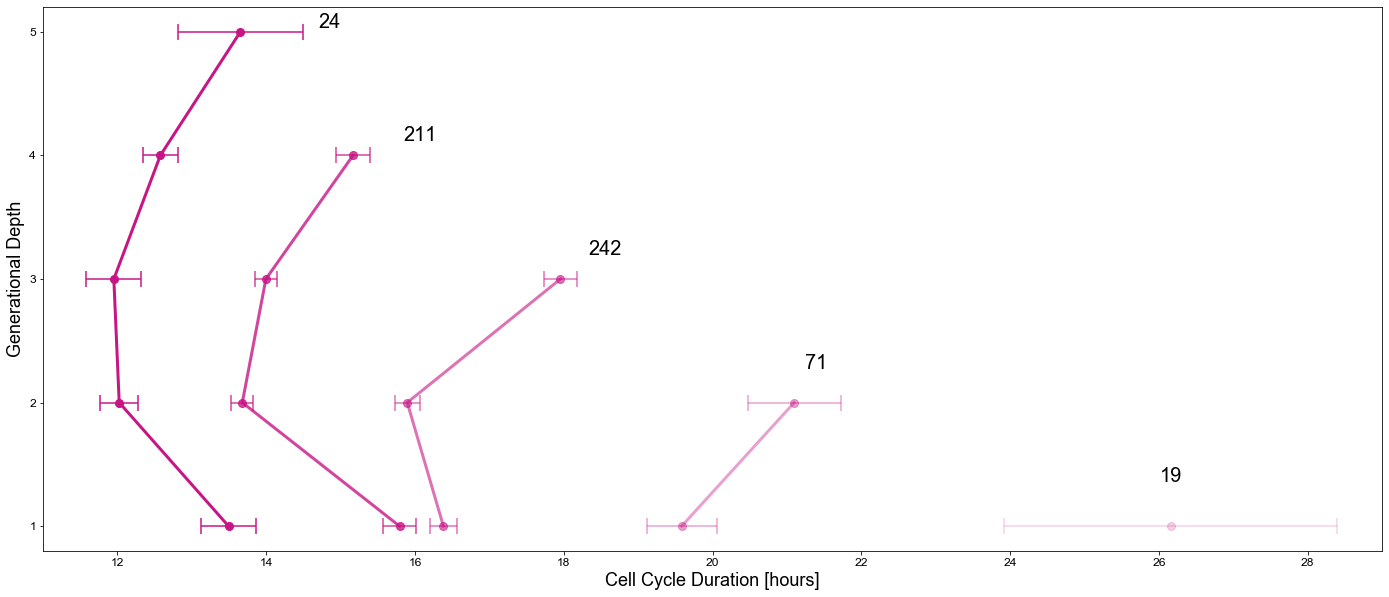

In [15]:
_ = plt.subplots(figsize=(24, 10))
mean_data = [[[] for _ in range(e+1)] for e, _ in enumerate(range(7))]

for enum, path in enumerate(hist_data[:-2]):
    
    for index in range(len(path)):
        
        mean = np.mean(path[index])
        sem = np.std(path[index]) / np.sqrt(len(path[index]))
        
        mean_data[len(path)-1][index].append([mean, sem])
        
        if index == 0:
            print ("Gen #1 mean = {} -> whole movie duration estimate = {}".format(round(mean, 2), round(mean * (enum + 3))))
            
        plt.errorbar(x=mean, y=index+1, xerr=sem, color="mediumvioletred", alpha=(enum+1)*0.2,
                     ecolor="mediumvioletred", elinewidth=1.5, capsize=8, capthick=1.5)
        plt.xlabel("Cell Cycle Duration [hours]", fontname="Arial", fontsize=18)
        plt.ylabel("Generational Depth", fontname="Arial", fontsize=18)
        plt.yticks(list(range(1, len(hist_data[:-2]) + 1)), fontname="Arial", fontsize=12)
        plt.xticks(fontname="Arial", fontsize=12)
        plt.xlim(11, 29)

        if index == len(path) - 1:
            plt.text(x=mean+enum*0.3, y=index+1 + 0.4 - enum*0.08, s=str(len(path[index])), 
                     fontname="Arial", fontsize=20, horizontalalignment='center', verticalalignment='center')
            
for eee, offspring_len in enumerate(mean_data[:-2]):
    plt.plot([item[0][0] for item in offspring_len], range(1, len([item[0][0] for item in offspring_len]) + 1), 
             marker='o', markersize=8, color="mediumvioletred", alpha=(eee+1)*0.2, linewidth=3.0, linestyle="solid", label=eee + 1)

plt.show()
plt.close()


### Done!